idea: The dataset may contain wrong labels. A solution is detect anomalies in the dataset using Gaussian Mixture, and then inspect the anomaly data points

In [435]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
from sklearn.semi_supervised import LabelPropagation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import auc, roc_curve, make_scorer, log_loss, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

In [332]:
import warnings
warnings.filterwarnings("ignore")

In [333]:
from glob import glob
glob('./*')

['./Predict_bad_loan.ipynb',
 './Loan_Dataset_3.csv',
 './Loan_Dataset.csv',
 './Predict_bad_loan_cont_(Unsupervised_&_Supervised_approach).ipynb',
 './Loan_Dataset_2.csv',
 './bad_data.csv',
 './Predict_bad_loan_cont_Anomaly_Detection_last_step.ipynb',
 './Predict_bad_loan_cont_Anomaly_Detection.ipynb',
 './Predict_bad_loan_cont_Anomaly_Detection_good_data.ipynb',
 './Predict_bad_loan_cont_(Dimensionality_Reduction_approach).ipynb',
 './Predict_bad_loan_cont_Anomaly_Detection_questionable_data.ipynb',
 './variable_descriptions',
 './good_data.csv']

In [334]:
df_good = pd.read_csv('good_data.csv')
df_bad = pd.read_csv('bad_data.csv')

In [335]:
df_bad.columns

Index(['id', 'annual_income', 'short_employee', 'emp_length_num',
       'Debt-To-Income Ratio', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_36 months',
       'term_60 months', 'last_delinq_none_0', 'last_delinq_none_1',
       'annual_income_log'],
      dtype='object')

In [436]:
def get_metrics(target_test, target_score, target_pred):
    precision, recall, thresholds = precision_recall_curve(target_test, target_score)
    fpr, tpr, thresholds = roc_curve(target_test, target_score)
    pr_auc = average_precision_score(target_test, target_score)
    roc_auc = auc(fpr, tpr)
    print(f'PR AUC is {pr_auc:.2f}. ROC AUC is {roc_auc:.2f}')
    return precision, recall, pr_auc, fpr, tpr, roc_auc

def get_confusion_matrix(target_test, target_pred):
    matrix = confusion_matrix(target_test, target_pred)
    df = pd.DataFrame(matrix, index=['Actual Negative', 'Actual Positive'], 
                 columns=['Predicted Negative', 'Predicted Positive'])
    return df

In [337]:
# X_good = df_good.drop(columns=['bad_loan'])
# y_good = df_good.bad_loan

# num_to_sample = X_good.shape[0]

# X_bad = df_bad.drop(columns=['bad_loan']).iloc[:num_to_sample]
# y_bad = pd.Series([-1]*num_to_sample)

In [338]:
# X_joined = pd.concat([X_good,X_bad])
# y_joined = pd.concat([y_good,y_bad])

In [339]:
# label_prop_model = LabelPropagation(n_neighbors=5,n_jobs=-1)
# label_prop_model.fit(X_joined, y_joined)
# X_bad_label = label_prop_model.predict(X_bad)
# X_bad_label.mean()

In [340]:
#use cosine similarity to compare similarity between good data with label 1 and bad data with label 0

df_joined = pd.concat([df_good, df_bad])
df_joined.shape

(18370, 36)

In [341]:
#dropping the target columns because of the assumption that bad data contains wrong labels
#dropping annual_income_log as it was an engineered feature that is not in the original dataset
#keeping the id column because when i use Gaussian Mixture/EM to get the good data, i kept id as well
df_joined_2 = df_joined.drop(columns=['bad_loan', 'annual_income_log'])
df_joined_2.head()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1
0,10166062,70000,0,7,13.85,61.2,0.0,0.324621,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
1,10117251,158000,0,2,0.23,25.5,0.0,0.552883,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
2,10167775,52000,0,11,21.21,87.4,0.0,0.042664,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,10147584,18500,1,1,2.92,6.7,0.0,0.212812,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,10177748,55000,0,2,24.11,57.9,0.0,0.604216,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1


In [343]:
scaler = StandardScaler()
df_joined_scaled = scaler.fit_transform(df_joined_2)

In [354]:
good_ones_ids = df_good[df_good.bad_loan==1].id.tolist()

In [416]:
good_zeros_ids = df_good[df_good.bad_loan==0].id.tolist()

In [358]:
bad_zeros_ids = df_bad[df_bad.bad_loan==0].id.tolist()

In [401]:
bad_ones_ids = df_bad[df_bad.bad_loan==1].id.tolist()

In [359]:
df_joined['placeholder'] = df_joined.id.apply(lambda x: x in good_ones_ids)

In [375]:
df_joined.placeholder.sum(), (df_good.bad_loan==1).sum()

(664, 664)

In [361]:
good_ones_inds = df_joined.index[df_joined['placeholder']==True].tolist()

In [397]:
good_ones.shape

(664, 33)

In [474]:
good_ones = df_joined_scaled[good_ones_inds, 1:]

In [378]:
df_joined['placeholder_2'] = df_joined.id.apply(lambda x: x in bad_zeros_ids)
df_joined.placeholder_2.sum(), (df_bad.bad_loan==0).sum()

(13672, 13672)

In [381]:
bad_zeros_inds = df_joined.index[df_joined['placeholder_2']==True].tolist()

In [484]:
bad_zeros = df_joined_scaled[bad_zeros_inds, :]

In [402]:
df_joined['placeholder_3'] = df_joined.id.apply(lambda x: x in bad_ones_ids)
df_joined.placeholder_3.sum(), (df_bad.bad_loan==1).sum()

(3019, 3019)

In [483]:
bad_ones_inds = df_joined.index[df_joined['placeholder_3']==True].tolist()
bad_ones = df_joined_scaled[bad_ones_inds, :]

In [417]:
df_joined['placeholder_4'] = df_joined.id.apply(lambda x: x in good_zeros_ids)
df_joined.placeholder_4.sum(), (df_good.bad_loan==0).sum()

(1015, 1015)

In [482]:
good_zeros_inds = df_joined.index[df_joined['placeholder_4']==True].tolist()
good_zeros = df_joined_scaled[good_zeros_inds, :]

In [429]:
def compute_avg_cosine_similarity(mat_a, mat_b):
    sim = mat_a.dot(mat_b.T)
    a_norm = np.linalg.norm(mat_a, axis=1, keepdims=True)
    b_norm = np.linalg.norm(mat_b, axis=1)
    cos_sim = sim/(a_norm*b_norm.T)
    return np.mean(cos_sim)

In [478]:
compute_avg_cosine_similarity(good_ones, bad_zeros)

-0.011254009399099414

In [479]:
compute_avg_cosine_similarity(good_ones, bad_ones)

-0.019917988988165002

In [485]:
compute_avg_cosine_similarity(good_zeros, bad_zeros)

-0.016251302916567966

In [486]:
compute_avg_cosine_similarity(good_zeros, bad_ones)

-0.015131083329933088

In [136]:
#since there is some evidence, i will switch the sign of the bad data labels
df_bad['bad_loan'] = df_bad['bad_loan'].apply(lambda x: (x+1)%2) 

In [138]:
df_joined = pd.concat([df_bad,df_good])

NameError: name 'df_good_loan' is not defined

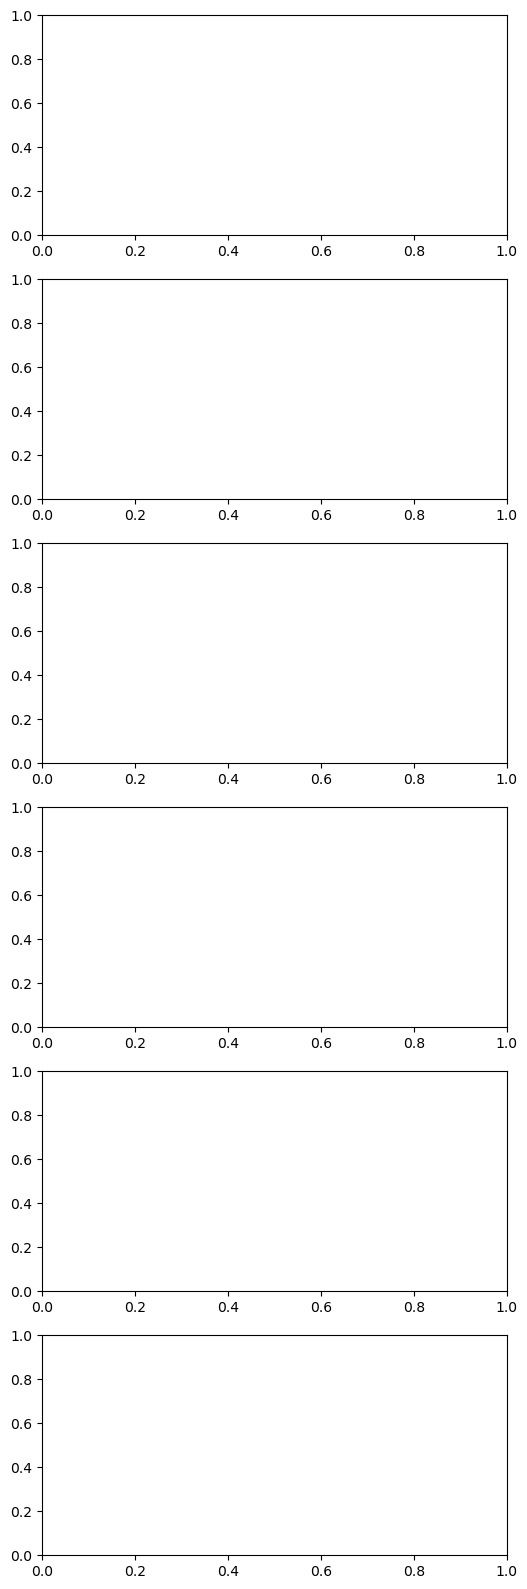

In [13]:
fig,ax = plt.subplots(6,1,figsize=(6,20))

sns.violinplot(y='annual_income_log',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[0]);

sns.violinplot(y='Debt-To-Income Ratio',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[1]);

sns.violinplot(y='revol_util',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[2]);

sns.violinplot(y='total_rec_late_fee',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[3]);

sns.violinplot(y='emp_length_num',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[4]);

sns.violinplot(y='od_ratio',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[5]);

In [ ]:
ind = df_good_loan.index

In [ ]:
df_no_dummy = pd.read_csv('Loan_Dataset_3.csv')
df_no_dummy.iloc[8,:]

In [ ]:
df_good_loan_2 = df_good_loan.copy() #df_____2 is for graphs
df_good_loan_2

In [ ]:
df_no_dummy.purpose[ind]

In [ ]:
df_good_loan_2['purpose'] = df_no_dummy.purpose[ind]
df_good_loan_2['grade'] = df_no_dummy.grade[ind]
df_good_loan_2['home_ownership'] = df_no_dummy.home_ownership[ind]
df_good_loan_2['term'] = df_no_dummy.term[ind]
df_good_loan_2['last_delinq_none'] = df_no_dummy.last_delinq_none[ind]

In [ ]:
fig,ax = plt.subplots(5,1,figsize=(6,30))
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

sns.countplot(x=df_good_loan_2.purpose, hue=df_good_loan_2.anomaly, ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Loan Purpose Distribution');

sns.countplot(x=df_good_loan_2.grade, hue=df_good_loan_2.anomaly, order=grade_order, ax=ax[1]);
ax[1].set_title('Loan Grade Distribution');

sns.countplot(x=df_good_loan_2.home_ownership, hue=df_good_loan_2.anomaly, ax=ax[2]);
ax[2].set_title('Home Ownership Distribution');

sns.countplot(x=df_good_loan_2.term, hue=df_good_loan_2.anomaly, ax=ax[3]);
ax[3].set_title('Loan Term Distribution');

sns.countplot(x=df_good_loan_2.last_delinq_none, hue=df_good_loan_2.anomaly, ax=ax[4]);
ax[4].set_title('Default Histroy');


In [ ]:
#do the same thing for df_bad_loan
gm_bad = GaussianMixture(n_components=2, n_init=20,random_state=123)
gm_bad.fit(df_bad_loan)
gm_bad.weights_

In [ ]:
gm_bad.converged_, gm_bad.n_iter_

In [ ]:
new_label = gm_bad.predict(df_bad_loan)

In [ ]:
new_label.sum(), new_label.size

In [ ]:
new_label.mean() 

In [ ]:
df_bad_loan.loc[:,'anomaly'] = (new_label+1)%2 #now 1 represents an anomaly tag
df_bad_loan['annual_income_log'] = df_bad_loan.annual_income.apply(lambda x: np.log(x+1))

In [ ]:
df_bad_loan[df_bad_loan['anomaly']==0].describe()

In [ ]:
df_bad_loan[df_bad_loan['anomaly']==1].describe()

In [ ]:
fig,ax = plt.subplots(6,1,figsize=(6,20))

sns.violinplot(y='annual_income_log',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[0]);

sns.violinplot(y='Debt-To-Income Ratio',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[1]);

sns.violinplot(y='revol_util',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[2]);

sns.violinplot(y='total_rec_late_fee',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[3]);

sns.violinplot(y='emp_length_num',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[4]);

sns.violinplot(y='od_ratio',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[5]);

In [ ]:
ind_bad = df_bad_loan.index

In [ ]:
df_bad_loan_2 = df_bad_loan.copy() #df_____2 is for graphs

In [ ]:
df_bad_loan_2['purpose'] = df_no_dummy.purpose[ind_bad]
df_bad_loan_2['grade'] = df_no_dummy.grade[ind_bad]
df_bad_loan_2['home_ownership'] = df_no_dummy.home_ownership[ind_bad]
df_bad_loan_2['term'] = df_no_dummy.term[ind_bad]
df_bad_loan_2['last_delinq_none'] = df_no_dummy.last_delinq_none[ind_bad]

fig,ax = plt.subplots(5,1,figsize=(6,30))
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

sns.countplot(x=df_bad_loan_2.purpose, hue=df_bad_loan_2.anomaly, ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Loan Purpose Distribution');

sns.countplot(x=df_bad_loan_2.grade, hue=df_bad_loan_2.anomaly, order=grade_order, ax=ax[1]);
ax[1].set_title('Loan Grade Distribution');

sns.countplot(x=df_bad_loan_2.home_ownership, hue=df_bad_loan_2.anomaly, ax=ax[2]);
ax[2].set_title('Home Ownership Distribution');

sns.countplot(x=df_bad_loan_2.term, hue=df_bad_loan_2.anomaly, ax=ax[3]);
ax[3].set_title('Loan Term Distribution');

sns.countplot(x=df_bad_loan_2.last_delinq_none, hue=df_bad_loan_2.anomaly, ax=ax[4]);
ax[4].set_title('Default Histroy');


In [ ]:
df_bad_loan.anomaly.sum()

In [ ]:
df_new = pd.concat([df_good_loan,df_bad_loan])

In [ ]:
df_new.shape

In [ ]:
df_norm = df_new[df_new.anomaly==0]
df_anom = df_new[df_new.anomaly==1]
df_norm.shape, df_anom.shape

In [140]:
df_joined.columns

Index(['id', 'annual_income', 'short_employee', 'emp_length_num',
       'Debt-To-Income Ratio', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_36 months',
       'term_60 months', 'last_delinq_none_0', 'last_delinq_none_1',
       'annual_income_log'],
      dtype='object')

In [141]:
X = df_joined.drop(columns=['id', 'annual_income','bad_loan','grade_A',
                     'home_ownership_MORTGAGE','purpose_car','term_36 months',
                     'last_delinq_none_0'])

y = df_joined['bad_loan'].astype(int)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [142]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

### Logistic Regression

In [439]:
param_grid = [{'C': [790, 800, 810]}]

lg_clf = LogisticRegression(class_weight='balanced',
                            random_state = 123
                           )
     
grid_search = GridSearchCV(lg_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)
               
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 800}

In [440]:
lg_clf = grid_search.best_estimator_
lg_clf.fit(X_train, y_train)
y_pred = lg_clf.predict(X_test)
y_score = lg_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,542,265
Actual Positive,611,2256


In [441]:
lg_precision, lg_recall, lg_pr_auc, lg_fpr, lg_tpr, lg_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.93. ROC AUC is 0.81


### XGBoost

In [442]:
param_grid = [
    {'n_estimators': [50, 60, 70, 80],
     'max_depth': [5, 6, 7, 8, 9, 10],
     'learning_rate': [0.01, 0.1, 1]}]

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='logloss',
                                    scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50}

In [443]:
xgb_classifier = grid_search.best_estimator_
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
y_score = xgb_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,219,588
Actual Positive,13,2854


In [445]:
xgb_precision, xgb_recall, xgb_pr_auc, xgb_fpr, xgb_tpr, xgb_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.93. ROC AUC is 0.81


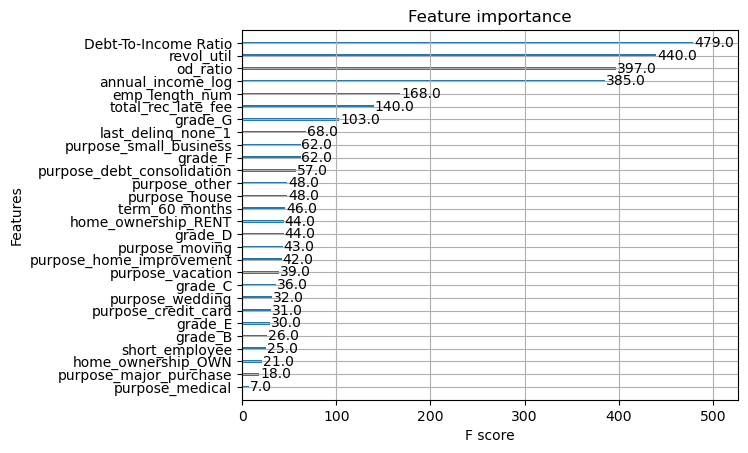

In [446]:
xgb_classifier.get_booster().feature_names =  list(X.columns)
xgb.plot_importance(xgb_classifier);

### Random Forest

In [447]:
param_grid = [
    {'n_estimators': [350, 400, 450],
     'max_depth': [5, 10, 15]}
]

rf_classifier = RandomForestClassifier(class_weight=class_weights,
                                       random_state = 123)

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 10, 'n_estimators': 400}

In [448]:
best_params = grid_search.best_estimator_
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
y_score = rf_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,259,548
Actual Positive,59,2808


In [449]:
rf_precision, rf_recall, rf_pr_auc, rf_fpr, rf_tpr, rf_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.92. ROC AUC is 0.78


In [450]:
feature_names = list(X.columns)
feature_importances = list()

for name, score in zip(feature_names, rf_classifier.feature_importances_):
    p = (name, score)
    feature_importances.append(p)

feature_importances = sorted(feature_importances, key=lambda x:x[1],reverse=True)
feature_importances

[('Debt-To-Income Ratio', 0.15510965886226152),
 ('revol_util', 0.14537801175908996),
 ('od_ratio', 0.13956296975887864),
 ('annual_income_log', 0.13924382655673734),
 ('emp_length_num', 0.07010002520974433),
 ('grade_F', 0.06211711819357181),
 ('term_60 months', 0.03232125268881546),
 ('purpose_small_business', 0.026906866627953004),
 ('last_delinq_none_1', 0.021345367925922204),
 ('grade_B', 0.019284038264851866),
 ('purpose_other', 0.017735284720585418),
 ('home_ownership_RENT', 0.017611306265321907),
 ('purpose_home_improvement', 0.015278954520317939),
 ('grade_D', 0.014884101322929416),
 ('purpose_debt_consolidation', 0.014084940211234983),
 ('grade_C', 0.013454752356881238),
 ('purpose_moving', 0.012835523525253136),
 ('purpose_credit_card', 0.011344588075093922),
 ('grade_E', 0.010525503528865835),
 ('purpose_house', 0.010143114463406945),
 ('home_ownership_OWN', 0.009443314907787048),
 ('total_rec_late_fee', 0.008633550707325636),
 ('short_employee', 0.008591517302369001),
 ('p

#### Gradient Descent Optimization

In [451]:
param_grid = [
    {'max_iter': list(range(0, 951, 100))}
]

sgd_clf = SGDClassifier(loss='log', 
                        learning_rate='optimal',
                        tol=1e-3,
                        class_weight=class_weights,
                        random_state = 123)

grid_search = GridSearchCV(sgd_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_iter': 100}

In [452]:
sgd_clf = grid_search.best_estimator_
sgd_clf.fit(X_train, y_train)
y_pred = sgd_clf.predict(X_test)
y_score = sgd_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,541,266
Actual Positive,644,2223


In [453]:
sgd_precision, sgd_recall, sgd_pr_auc, sgd_fpr, sgd_tpr, sgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.92. ROC AUC is 0.80


### Mini-batch Gradient Descent

In [454]:
from sklearn.base import clone

batch_size = 150
sample_size = len(X_train)

#set aside a validation batch for mini-batch SGD
sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=batch_size, train_size=sample_size-batch_size)
train_ind, val_ind = next(sss_2.split(X_train, y_train))
X_train_2, y_train_2, X_mini_val, y_mini_val = X_train[list(train_ind)], y_train.iloc[train_ind], X_train[list(val_ind)], y_train.iloc[val_ind]
y_train_2 = y_train_2.to_numpy().reshape(-1,1)
combined_training_data = np.concatenate((X_train_2, y_train_2), axis = 1)

minimum_val_error = float("inf") 
best_model = None

for i in range(100):
    
    np.random.shuffle(combined_training_data)
    
    X_mini_train = combined_training_data[0:batch_size, :-1]
    y_mini_train = combined_training_data[0:batch_size, -1]
                                          
    sgd_clf.partial_fit(X_mini_train, y_mini_train, classes=np.unique(y_train_2))
    y_val_proba = sgd_clf.predict_proba(X_mini_val)
    val_error = log_loss(y_mini_val, y_val_proba)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_model = clone(sgd_clf)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)


,Predicted Negative,Predicted Positive
Actual Negative,541,266
Actual Positive,644,2223


In [455]:
mbgd_precision, mbgd_recall, mbgd_pr_auc, mbgd_fpr, mbgd_tpr, mbgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.92. ROC AUC is 0.80


In [456]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, log_loss, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

### Support Vector Machine

#### Linear SVM

In [457]:
param_grid = [
    {'max_iter': np.arange(2, 8, 1),
     'C': np.arange(1, 15, 1)}
]

lin_svm_clf = LinearSVC(dual=False, 
                        loss='squared_hinge',
                        random_state=123,
                        class_weight='balanced')

grid_search = GridSearchCV(lin_svm_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 14, 'max_iter': 7}

In [458]:
from sklearn.calibration import CalibratedClassifierCV

lin_svm_clf = grid_search.best_estimator_
lin_svm_clf.fit(X_train, y_train)
y_pred = lin_svm_clf.predict(X_test)

clf = CalibratedClassifierCV(grid_search.best_estimator_) 
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:,1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,541,266
Actual Positive,593,2274


In [459]:
lsvm_precision, lsvm_recall, lsvm_pr_auc, lsvm_fpr, lsvm_tpr, lsvm_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.93. ROC AUC is 0.81


#### Polynomial Kernel Support Vector Classifier

SVC's time complexity is O(n^2 xd) to O(n^3 xd). To lower the time required to train kernel SVM models, i will use a smaller training dataset

In [460]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, train_size=0.2, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train_2, y_train_2, X_test_2, y_test_2 = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

In [461]:
param_grid = [
    {'degree': [0, 1, 2],
     'coef0': [1, 2],
     'C': [1, 10, 100, 1000]}
]

poly_kernel_svm_clf = SVC(kernel = 'poly',
                          probability = True,
                          class_weight=class_weights)

grid_search = GridSearchCV(poly_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True,
                          n_jobs=-1)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 100, 'coef0': 1, 'degree': 1}

In [462]:
poly_kernel_svm_clf = grid_search.best_estimator_
poly_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = poly_kernel_svm_clf.predict(X_test_2)
y_score = poly_kernel_svm_clf.predict_proba(X_test_2)[:, 1]

get_confusion_matrix(y_test_2, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1862,1365
Actual Positive,2235,9234


In [464]:
pksvm_precision, pksvm_recall, pksvm_pr_auc, pksvm_fpr, pksvm_tpr, pksvm_roc_auc = get_metrics(y_test_2, y_score, y_pred)

PR AUC is 0.92. ROC AUC is 0.80


#### Gaussian RBF Kernel Support Vector Classifier

In [465]:
param_grid = [
    {'gamma': [0.0001, 0.001, 0.01, 0.1],
     'C': [0.1, 1, 10, 100, 1000]}
]
#https://scikit-learn.org/stable/modules/svm.html#svm-kernels
rbf_kernel_svm_clf = SVC(kernel = 'rbf',
                         probability = True,
                         class_weight=class_weights)

grid_search = GridSearchCV(rbf_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True,
                          n_jobs=-1)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 1000, 'gamma': 0.0001}

In [466]:
rbf_kernel_svm_clf = grid_search.best_estimator_
rbf_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = rbf_kernel_svm_clf.predict(X_test_2)
y_score = rbf_kernel_svm_clf.predict_proba(X_test_2)[:, 1]

get_confusion_matrix(y_test_2, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1860,1367
Actual Positive,2233,9236


In [467]:
rbfksvm_precision, rbfksvm_recall, rbfksvm_pr_auc, rbfksvm_fpr, rbfksvm_tpr, rbfksvm_roc_auc = get_metrics(y_test_2, y_score, y_pred)

PR AUC is 0.92. ROC AUC is 0.80


#### Stacking/Stacked Generalization

In [468]:
base_learners = [
    ('rf', rf_classifier),
    ('sgd', sgd_clf),
    ('xgb', xgb_classifier),
]

meta_learner = LogisticRegression(class_weight=class_weights)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
y_score = stacking_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,526,281
Actual Positive,599,2268


In [469]:
stack_precision, stack_recall, stack_pr_auc, stack_fpr, stack_tpr, stack_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.93. ROC AUC is 0.81


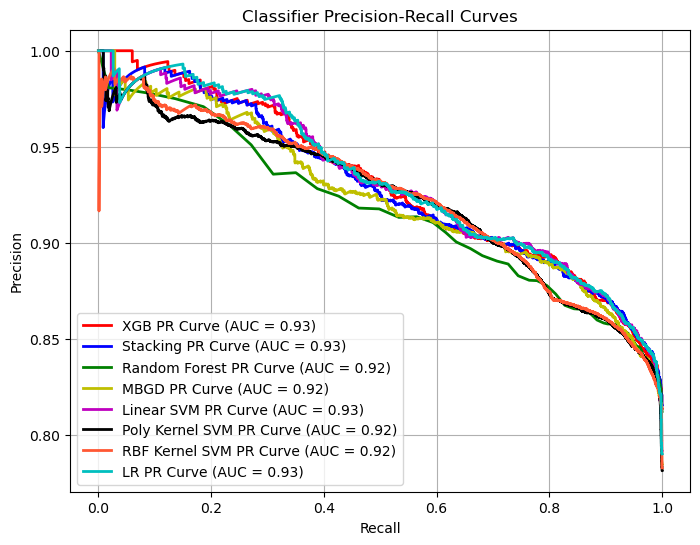

In [470]:
plt.figure(figsize=(8, 6))

plt.plot(xgb_recall, xgb_precision, color='r', lw=2, label=f'XGB PR Curve (AUC = {xgb_pr_auc:.2f})')
plt.plot(stack_recall, stack_precision, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_pr_auc:.2f})')
plt.plot(rf_recall, rf_precision, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_pr_auc:.2f})')
plt.plot(mbgd_recall, mbgd_precision, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_pr_auc:.2f})')
plt.plot(lsvm_recall, lsvm_precision, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_pr_auc:.2f})')
plt.plot(pksvm_recall, pksvm_precision, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_pr_auc:.2f})')
plt.plot(rbfksvm_recall, rbfksvm_precision, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_pr_auc:.2f})')
plt.plot(lg_recall, lg_precision, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Classifier Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

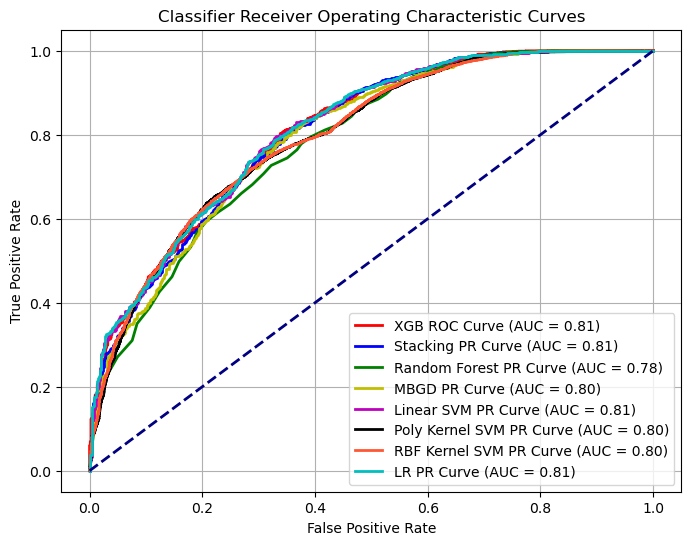

In [473]:
plt.figure(figsize=(8, 6))

plt.plot(xgb_fpr, xgb_tpr, color='r', lw=2, label=f'XGB ROC Curve (AUC = {xgb_roc_auc:.2f})')
plt.plot(stack_fpr, stack_tpr, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_roc_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_roc_auc:.2f})')
plt.plot(mbgd_fpr, mbgd_tpr, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_roc_auc:.2f})')
plt.plot(lsvm_fpr, lsvm_tpr, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_roc_auc:.2f})')
plt.plot(pksvm_fpr, pksvm_tpr, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_roc_auc:.2f})')
plt.plot(rbfksvm_fpr, rbfksvm_tpr, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_roc_auc:.2f})')
plt.plot(lg_fpr, lg_tpr, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Receiver Operating Characteristic Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()